# CSCA 5632 Final Project

## Step 1 - Gather Data

### Citation:

ISOLET. (1994). UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/54/isolet

This dataset is a matrix consisting of 7797 rows and 617 different features or columns. The data was collected as audio samples of single letter names spoken by many different subjects. The audio data was processed into 617 attributes (which are all labeled attribute1, attribute2, etc.), where each value per column is a scalar value that was extracted from the audio data by some method. The goal of this dataset is to correctly identify the letters spoke by new test subjects that the models have not been trained on.

## Step 2 - Identify an Unsupervised Learning Problem

### Project Topic

This project is about learning to use different components of unsupervised machine learning in coordination with supervised machine learning methods to more effectivlely analyze and model classification datasets.

The models and methods that will be used in this project are as follows:
- Unsupervised:
    - Principal Component Analysis (PCA)
    - Matrix Factorization (SVD)
    - Matrix Factorization (NMF)
    - Agglomerative Clustering
    - K-Means Clustering
- Supervised:
    - Logistic Regression

The problem that these moddels will be evaluated on is to predict the letter that was spoken by the test subject which produced the row of features in the dataset.

### Project Goal

The goal of this project is to identify the best performing model for this problem and also to note any poor performance of models or methods on this dataset.

## Step 3 - Exploratory Data Analysis

In [1]:
# Handle initial Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import itertools
from collections import Counter

### Initial Data Inspection

Lets start by loading in the data:

In [2]:
# Load the data
X_path = "x_iso.csv"
y_path = "y_iso.csv"

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

### Basic Data Inspection

Lets take a look at our X data

In [3]:
#Inspect the X-Data
print(X.head())
print("")

print("Shape of X Data:")
print(X.shape)

print("")
x_columns = X.columns.tolist()
print("X-Data Columns:")
print(x_columns)

   Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0     -0.4394     -0.0930      0.1718      0.4620      0.6226      0.4704   
1     -0.4348     -0.1198      0.2474      0.4036      0.5026      0.6328   
2     -0.2330      0.2124      0.5014      0.5222     -0.3422     -0.5840   
3     -0.3808     -0.0096      0.2602      0.2554     -0.4290     -0.6746   
4     -0.3412      0.0946      0.6082      0.6216     -0.1622     -0.3784   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute608  \
0      0.3578      0.0478     -0.1184      -0.2310  ...        0.3334   
1      0.4948      0.0338     -0.0520      -0.1302  ...        0.2272   
2     -0.7168     -0.6342     -0.8614      -0.8318  ...        0.0952   
3     -0.6868     -0.6650     -0.8410      -0.9614  ...        0.0648   
4     -0.4324     -0.4358     -0.4966      -0.5406  ...        0.2812   

   Attribute609  Attribute610  Attribute611  Attribute612  Attribute613  \
0        0.4102        

As we can see, this data has 617 features. It does not make sense to look at every single histogram - so we can randomly sample a few.

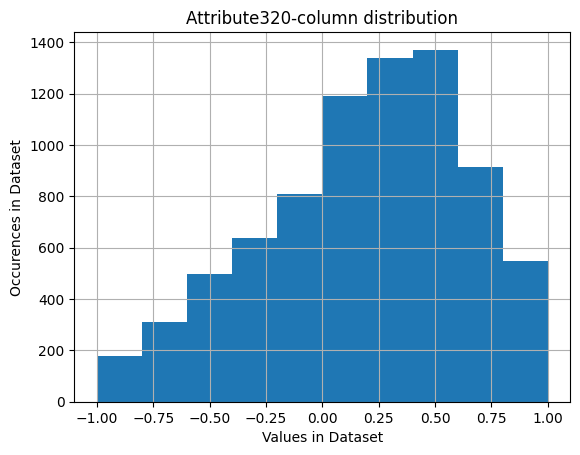

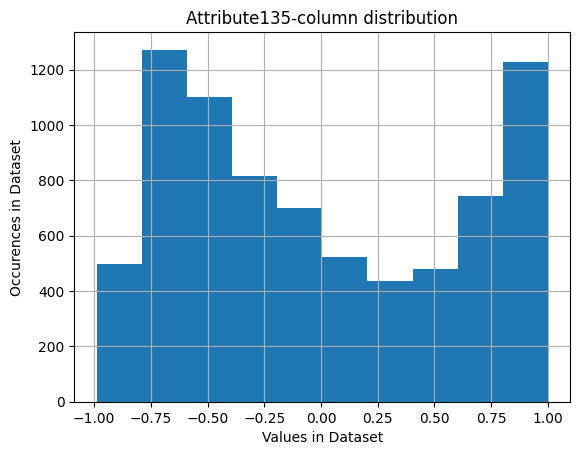

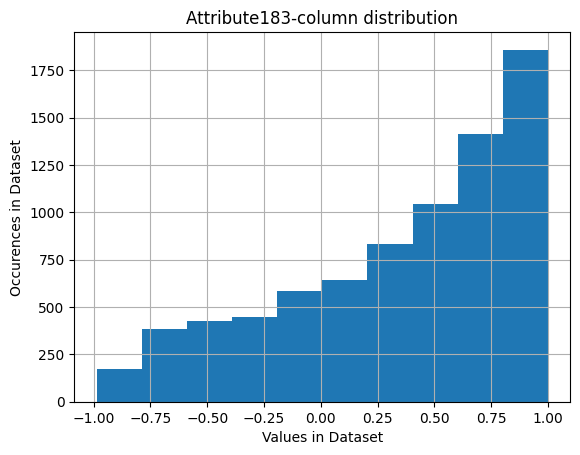

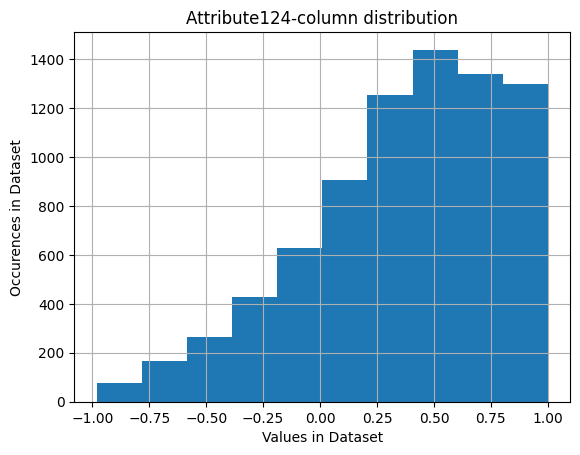

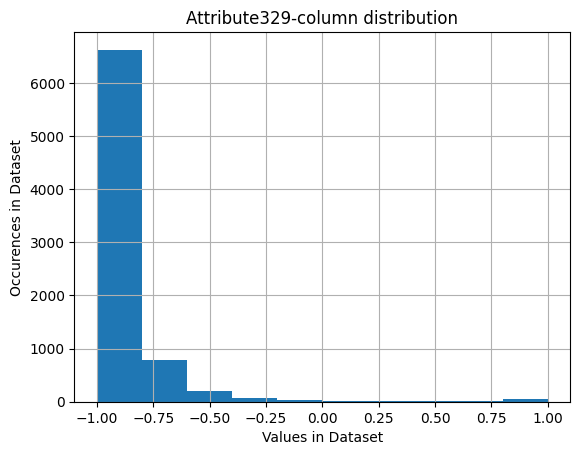

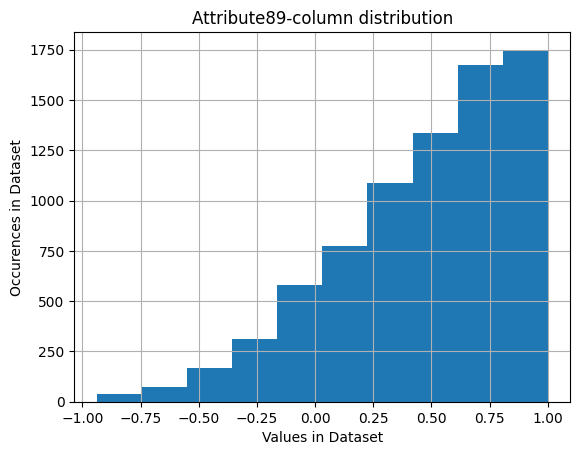

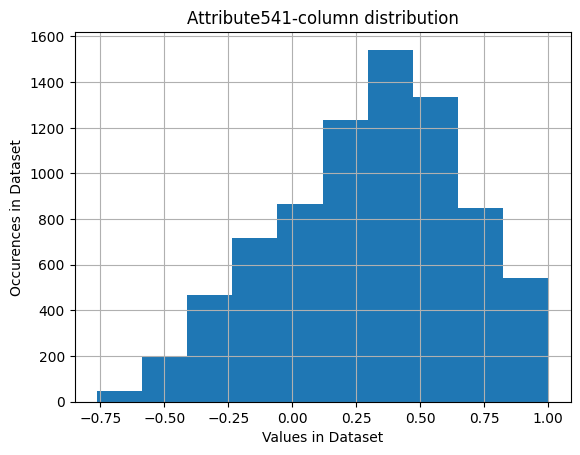

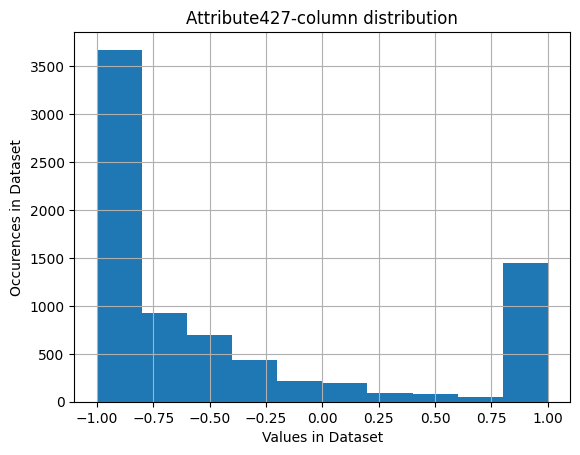

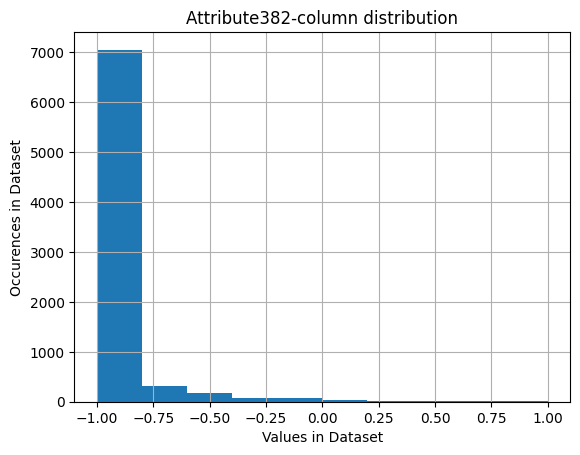

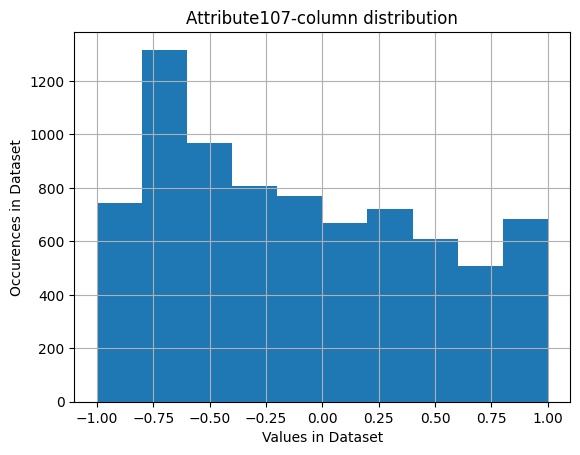

In [4]:
#Randomly sample 10 columns
sampled_columns = []
for i in range(10):
    randy = np.random.randint(0,610)
    sampled_columns.append(x_columns[randy])

for col in sampled_columns:
    #Get a histogram of the data
    dat = X[col].tolist()
    plt.hist(dat)
    plt.title("{}-column distribution".format(col))
    plt.grid()
    plt.xlabel("Values in Dataset")
    plt.ylabel("Occurences in Dataset")
    plt.show()

From these histograms, we can see some useful information about our features. The first thing to note is that each of the features sampled produce a histogram that clearly shows significant variation in the values within. Some are more lopsided than others but that is not necessarily a problem.

It would however be a problem if there was little to no variation present in one of the histograms. Since its unrealistic to check all of the features, lets write a script to do this for us

Number of features with a only single value: 0
Number of features with only two values: 4
Number of features with only three values: 0


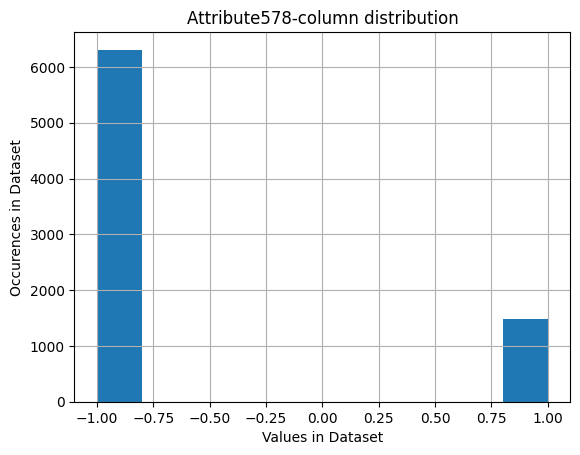

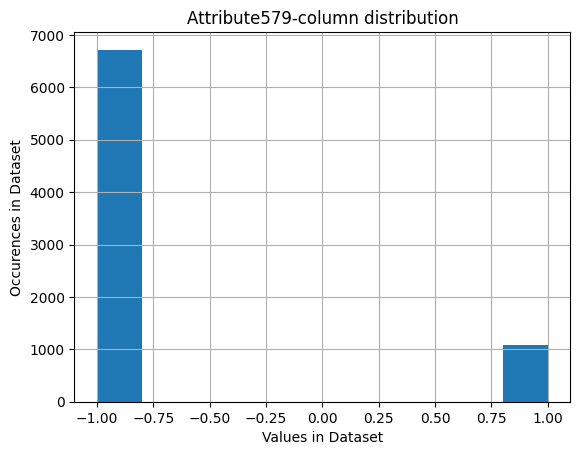

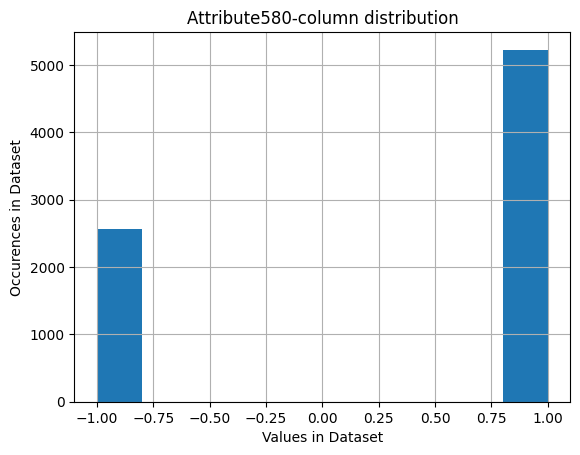

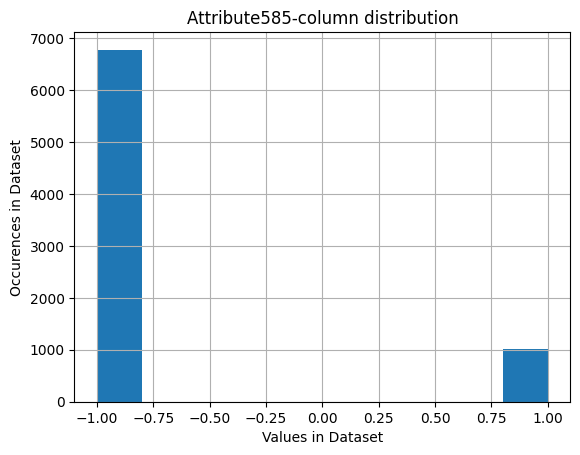

In [5]:
def analyze_features():
    """
    Perform analysis on Features to see if there are any that should be excluded due to lack of variation in data
    """
    single_value = []
    two_values = []
    three_values = []
    for col in x_columns:
        datlen = len(X[col].unique().tolist())
        if datlen < 2:
            single_value.append(col)
        elif datlen <3:
            two_values.append(col)
        elif datlen <4:
            three_values.append(col)

    print("Number of features with a only single value: {}".format(len(single_value)))
    print("Number of features with only two values: {}".format(len(two_values)))
    print("Number of features with only three values: {}".format(len(three_values)))
    return single_value, two_values, three_values

uno, dos, tres = analyze_features()
for col in dos:
    dat = X[col].tolist()
    plt.hist(dat)
    plt.title("{}-column distribution".format(col))
    plt.grid()
    plt.xlabel("Values in Dataset")
    plt.ylabel("Occurences in Dataset")
    plt.show()


It looks like we have no features that only contain a single value, so we do not need to drop any features on this account. Also it can be seen that there are 4 features which are binary - either valued -1 or 1. These are fine to be kept in the model for now.

Lets take a look what categories are present for us to predict to:

   class
0    1.0
1    1.0
2    2.0
3    2.0
4    3.0

Shape of y Data:
(7797, 1)


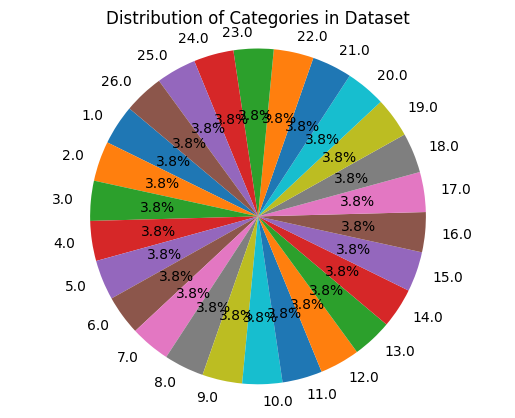

In [6]:
#Initial Y-Data Inspection
def simple_pie_chart_categories(df):
    """
    Generate a simple pie chart of the categories distribution in the dataset
    """
    categories = df["class"].unique().tolist()
    values = []
    for cat in categories:
        values.append((df["class"]==cat).sum())

    plt.pie(values, labels=categories, autopct="%1.1f%%", startangle=140)
    plt.title("Distribution of Categories in Dataset")
    plt.axis('equal')

    plt.show()

print(y.head())
print("")

print("Shape of y Data:")
print(y.shape)

simple_pie_chart_categories(y)


As we can see - the data is perfectly evenly distributed among each letter in the alphabet (letters 1 - 26). Also, nicely for us, these categories are already encoded as number values

### Analysis of Correlation

Lets take a look at the correlation matrix for this data:

In [7]:
# Lets Take a Look at the Correlation Matrix Data
correlation = X.corr()

print(correlation.head())
print(correlation.shape)

            Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  \
Attribute1    1.000000    0.736602    0.614495    0.324390   -0.139708   
Attribute2    0.736602    1.000000    0.788280    0.336946   -0.197423   
Attribute3    0.614495    0.788280    1.000000    0.613879   -0.130716   
Attribute4    0.324390    0.336946    0.613879    1.000000    0.483355   
Attribute5   -0.139708   -0.197423   -0.130716    0.483355    1.000000   

            Attribute6  Attribute7  Attribute8  Attribute9  Attribute10  ...  \
Attribute1   -0.230325   -0.222635   -0.249489   -0.282582    -0.309187  ...   
Attribute2   -0.333511   -0.303079   -0.330312   -0.369792    -0.396866  ...   
Attribute3   -0.313577   -0.310561   -0.355672   -0.396676    -0.420483  ...   
Attribute4    0.218398    0.115870    0.055520    0.011950    -0.020887  ...   
Attribute5    0.870960    0.762769    0.703255    0.663815     0.623211  ...   

            Attribute608  Attribute609  Attribute610  Attribute611  \
Attr

Again, for the same reason for skipping plotting all 617 histograms, this 617x617 matrix is far too large to visualize in a correlation heat map, so we will have to programatically analyze this dataset for features to exclude. Typically, any correlation value that has an absolute value of >0.7 is something with high correlation. We will use this threshold to decide on which columns to drop

In [8]:
def create_drop_list(mask):
    """
    Create a list of Column indicies to drop given the provided mask
    """
    indices = np.where(mask)
    result = list(zip(indices[0], indices[1]))

    to_drop = []
    for item in result:
        if item[0] == item[1]:
            pass
        else:
            if item[0] not in to_drop and item[1] not in to_drop:
                if item[0]>item[1]:
                    to_drop.append(item[0])
                else:
                    to_drop.append(item[1])
    return to_drop

#Get rid of everything
mask = correlation > 0.7
to_drop1 = create_drop_list(mask)
mask = correlation < -0.7
to_drop2 = create_drop_list(mask)

to_drop3 = to_drop1
for i in to_drop2:
    if i not in to_drop3:
        to_drop3.append(i)

columns_to_drop =[]
for i in to_drop3:
    columns_to_drop.append(X.columns[i])

X_reduced = X.drop(columns = columns_to_drop)

print("Shape of matrix after dropping highly correlated features:")
print(X_reduced.shape)

Shape of matrix after dropping highly correlated features:
(7797, 193)


Alright! We got rid of 424 Columns! Nice! Lets take a look at the maximum correlation remaining to make sure we were successful:

In [10]:
# Show the maximum and minimum correlation left over
reduced_correlation_matrix = X_reduced.corr()

#fill the diagonal values so that we dont get that as our max
reduced_correlation_matrix_for_measure = np.fill_diagonal(reduced_correlation_matrix.values, 0)

max_remaining_correlation = reduced_correlation_matrix.values.max()
min_remaining_correlation = reduced_correlation_matrix.values.min()

print("Max Remaining Correlation: {}".format(max_remaining_correlation))
print("Min Remaining Correlation: {}".format(min_remaining_correlation))

Max Remaining Correlation: 0.6996777497251019
Min Remaining Correlation: -0.6930861874696155


Nice! It was successful. We can use all of the remaining features in the dataset.

The last cleaning step we need to take care of is to check for any missing values.

In [11]:
total_missing_values = X_reduced.isna().sum().sum()
print("Total missing values in the data set:")
print(total_missing_values)


Total missing values in the data set:
0


Ok! There are no missing values to deal with. 

### Data Transformation

If we go ahead and take a look at our data so far we can see that there are negative values present.


In [12]:
print(X_reduced.head())

   Attribute1  Attribute3  Attribute4  Attribute5  Attribute9  Attribute13  \
0     -0.4394      0.1718      0.4620      0.6226     -0.1184      -0.2620   
1     -0.4348      0.2474      0.4036      0.5026     -0.0520      -0.0494   
2     -0.2330      0.5014      0.5222     -0.3422     -0.8614      -0.4986   
3     -0.3808      0.2602      0.2554     -0.4290     -0.8410      -0.6772   
4     -0.3412      0.6082      0.6216     -0.1622     -0.4966      -0.4494   

   Attribute16  Attribute19  Attribute21  Attribute23  ...  Attribute601  \
0      -0.0564       0.4226       0.9184       0.9324  ...        0.3590   
1       0.0704       0.5652       0.7760       0.8542  ...        0.6590   
2      -0.5428      -0.0472       0.6136       1.0000  ...       -0.0158   
3      -0.6240      -0.2168       0.3832       0.8988  ...        0.1224   
4      -0.1148       0.4864       0.9560       0.7770  ...        0.2500   

   Attribute602  Attribute603  Attribute604  Attribute606  Attribute608  \

We should remedy this by normalizing our data. To do this, we can use the sklearn MinMaxScaler module.

OF NOTE: Due to the amount of features present, this normalization will take care of outliers - rendering the feature practically inert. So we are not worried about any outliers with this dataset

In [13]:
scaler = MinMaxScaler()
X_normalized  = pd.DataFrame(scaler.fit_transform(X_reduced), columns=X_reduced.columns)

X_normalized.head()

,Attribute1,Attribute3,Attribute4,Attribute5,Attribute9,Attribute13,Attribute16,Attribute19,Attribute21,Attribute23,...,Attribute601,Attribute602,Attribute603,Attribute604,Attribute606,Attribute608,Attribute610,Attribute612,Attribute615,Attribute617
0,0.2803,0.580701,0.726626,0.810979,0.4408,0.360883,0.465114,0.705107,0.957632,0.966074,...,0.642379,0.824829,0.664526,0.489071,0.768731,0.585808,0.552276,0.625540,0.798337,0.256640
1,0.2826,0.618975,0.696951,0.750876,0.4740,0.468551,0.529316,0.777937,0.883697,0.926829,...,0.809752,0.534055,0.662148,0.629513,0.931690,0.519821,0.603087,0.694590,0.680822,0.470525
2,0.3835,0.747570,0.757215,0.327757,0.0693,0.241061,0.218835,0.465169,0.799377,1.000000,...,0.433274,0.837244,1.000000,0.645333,0.370054,0.437803,0.409869,0.434397,0.580946,0.262578
3,0.3096,0.625456,0.621646,0.284283,0.0795,0.150613,0.177722,0.378550,0.679751,0.949212,...,0.510377,0.729613,0.666310,0.409250,0.627901,0.418914,0.416404,0.495619,0.434221,0.438134
4,0.3294,0.801640,0.807724,0.417910,0.2517,0.265978,0.435544,0.737692,0.977155,0.888086,...,0.581567,1.000000,0.962897,0.603792,0.379916,0.553374,0.612663,0.361023,0.613751,0.384690


### On Feature Importance

Since all of the featuers are labeled simply as "Attribute" it is very difficult to determine which features might have more importance than others. The good news is that we can use PCA to analyze the importance of all of our features

In [14]:
pca = PCA()
pca.fit(X_normalized)

importance_matrix = np.abs(pca.components_[0])
importance_df = pd.DataFrame(importance_matrix, index=X_normalized.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)

print("10 most important:")
print(importance_df.head(10))

print("\n10 least important:")
print(importance_df.tail(10))

print("\nMean Importance:")
print(importance_df["Importance"].mean())


10 most important:
              Importance
Attribute140    0.187068
Attribute168    0.172048
Attribute76     0.165301
Attribute397    0.154417
Attribute425    0.152950
Attribute205    0.151868
Attribute143    0.148637
Attribute517    0.147319
Attribute362    0.146437
Attribute9      0.145711

10 least important:
              Importance
Attribute407    0.005419
Attribute331    0.005269
Attribute115    0.003116
Attribute378    0.002858
Attribute345    0.002625
Attribute557    0.002142
Attribute334    0.001758
Attribute242    0.001696
Attribute50     0.001683
Attribute375    0.000932

Mean Importance:
0.05847181434969019


As we can see there is a spectrum of importance of each feature, ranging from .187 for most important to .001 for least important. We could most likely drop the least important features without consequence, but it is not necessary. Also of note - the mean importance is .05 which indicates that much of our features do have significant importance relative to the most and least important features.

## Step 4 - Perform Analysis using Unsupervised Models of your Choice

- Compare multiple models
- Show why some models work better than others
- At least one of your methods should be an unsupervised approach
- Must use hyperparameter tuning

### Model Building

Lets define some useful methods for us to build our models

In [15]:
def perform_svd(matrix, n_components = 5):
    """
    Perform Single Value Decomposition - Matrix Factorization technique

    Provide normalized data matrix
    """
    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(matrix)
    X_svd_df = pd.DataFrame(X_svd)
    return X_svd_df

def perform_nmf(matrix, n_components = 5):
    """
    Perform Non Negative Matrix Factorization,
    
    Provide Normalized data matrix
    """    
    model = NMF(n_components = n_components, init='random', random_state=0)
    X_nmf = model.fit_transform(matrix)
    X_nmf_df = pd.DataFrame(X_nmf)
    return X_nmf_df

In [16]:
def perform_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Simple Logistic Regression Model to train our data on
    """
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    # print(classification_report(y_test, y_pred))

    return accuracy_score(y_test, y_pred)  
    

### Tune SVD Hyperparameters

c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d 

[0.55, 0.7602564102564102, 0.8352564102564103, 0.8589743589743589, 0.882051282051282, 0.9064102564102564, 0.9153846153846154, 0.9102564102564102, 0.9173076923076923, 0.9217948717948717, 0.9294871794871795, 0.9301282051282052, 0.9352564102564103, 0.9346153846153846, 0.9403846153846154, 0.9397435897435897]


c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


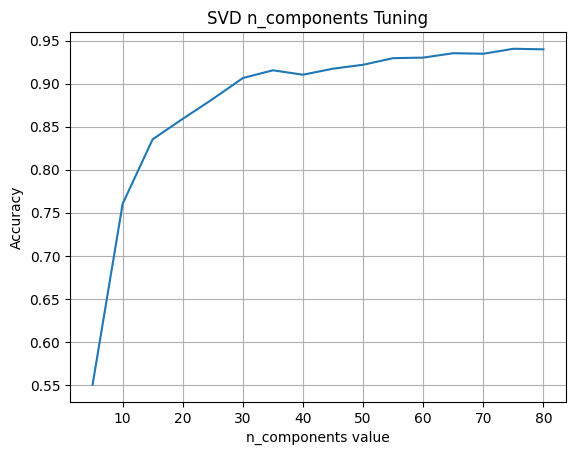

In [91]:
component_numbers = [i+1 for i in range(9)]
component_numbers = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

accs = []
for cn in component_numbers:
    X_svd = perform_svd(X_normalized, n_components = cn)

    X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)
    ans = perform_logistic_regression(X_train, X_test, y_train, y_test)
    accs.append(ans)
print(accs)
plt.plot(component_numbers, accs)
plt.grid()
plt.title("SVD n_components Tuning")
plt.xlabel("n_components value")
plt.ylabel("Accuracy")
plt.show()

### Tune NMF Hyperparameters

c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

[0.5224358974358975, 0.7288461538461538, 0.75, 0.7685897435897436, 0.8147435897435897, 0.8205128205128205, 0.833974358974359, 0.8551282051282051, 0.8397435897435898, 0.8423076923076923, 0.8474358974358974, 0.8551282051282051, 0.8371794871794872, 0.8596153846153847, 0.8384615384615385, 0.8512820512820513]


c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


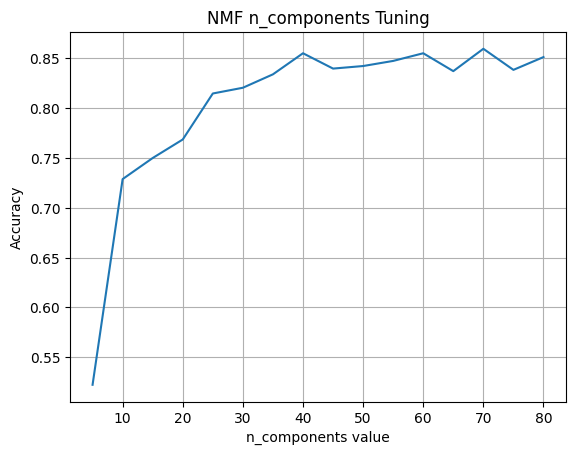

In [92]:
component_numbers = [i+1 for i in range(9)]
component_numbers = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

accs = []
for cn in component_numbers:
    X_nmf = perform_nmf(X_normalized, n_components = cn)

    X_train, X_test, y_train, y_test = train_test_split(X_nmf, y, test_size=0.2, random_state=42)
    ans = perform_logistic_regression(X_train, X_test, y_train, y_test)
    accs.append(ans)
print(accs)
plt.plot(component_numbers, accs)
plt.title("NMF n_components Tuning")
plt.grid()
plt.xlabel("n_components value")
plt.ylabel("Accuracy")
plt.show()

Alright so we can see that SVD performed best at: n_components=80, but it starts to level off at n_components = 60. We can also see that SVD outperformed NMF, so lets only consider SVD moving forward in this project.

Before we model the Unsupervised Clustering Methods - we will need a way to translate their generated groupings into the actual labels. 

We cannot use the label_permute_compare method that was made in our Course Programming assignments as it is too slow to compare all of the possibilities. Instead I wrote something less precise but more efficient below:

In [66]:
def find_best_labels(prediction, truth):
    """
    Find the best labels that match the truth predictions

    Designed to be fast to handle selection of 26 labels
    """
    truth = [int(i) for i in truth]
    #alright I need a quick way to do this
    #for each value, find the best performing value
    most_common_items = []
    for i in range(1,27):
        indicies = np.where(prediction == i)[0].tolist()

        #get all values from the list:
        could_be = []
        for ind in indicies:
            could_be.append(truth[ind])

        counter = Counter(could_be)
        try:
            most_common = counter.most_common(1)[0][0]
        except:
            most_common_items.append(-1)
        most_common_items.append(most_common)
    
    predictions2 = []
    for p in prediction:
        collab = most_common_items[p-1]
        if collab <0:
            predictions2.append(1)
        else:
            predictions2.append(collab)

    acc = accuracy_score(predictions2,y["class"].tolist())
    return acc


### Define Clustering Methods

In [81]:
def perform_agglomerative_clustering(matrix, linkage = 'average', affinity = 'euclidean'):
    """
    Handle Agglomerative Clustering Model Creation
    """
    model = AgglomerativeClustering(n_clusters=26, linkage=linkage, affinity=affinity)
    model.fit(matrix)

    labels = model.labels_
    acc = find_best_labels(labels, y["class"].tolist())
    print("Accuracy: {}".format(acc))
    return acc


def perform_kmeans_clustering(matrix, n_init):
    """
    Handle Kmeans clustering Model Creation
    """
    model = KMeans(n_clusters=26, n_init=n_init, random_state=42)
    model.fit(matrix)
    
    labels = model.labels_
    acc = find_best_labels(labels, y["class"].tolist())
    print("Accuracy: {}".format(acc))
    return acc

# perform_agglomerative_clustering(X_normalized)
# perform_kmeans_clustering(X_normalized)


### Tune Agglomerative Clustering Hyperparameters

c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Accuracy: 0.5143003719379249


c:\Users\Ben\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Accuracy: 0.3905348210850327


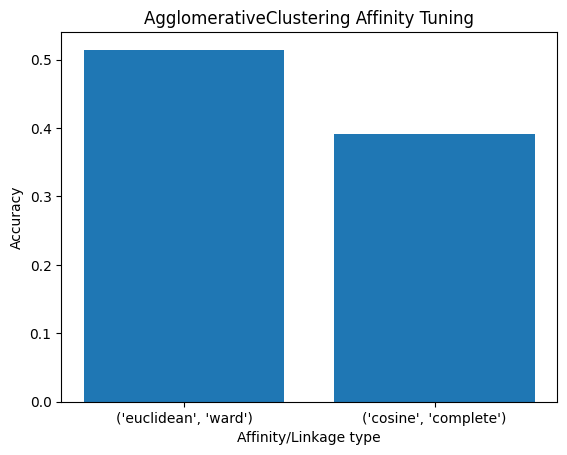

In [89]:
#Hyperparameters to tune for Agglomerative 
affinities = ["euclidean", "manhattan", "cosine"]
linkages = ["ward", "euclidean", "complete", "average", "single"]

# perform_agglomerative_clustering(X_normalized, affinity='euclidean', linkage='ward')
settings = []
accs = []
for a, l in zip(affinities, linkages):
    try:
        accs.append(perform_agglomerative_clustering(X_normalized, affinity=a, linkage=l))
        settings.append(str((a,l)))
    except:
        pass
plt.bar(settings, accs)
plt.title("AgglomerativeClustering Affinity Tuning")
plt.ylabel("Accuracy")
plt.xlabel("Affinity/Linkage type")
plt.show()


### Tune KMeans Clustering Hyperparameters

Accuracy: 0.5271258176221624
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5575221238938053
Accuracy: 0.5472617673464153
Accuracy: 0.5472617673464153


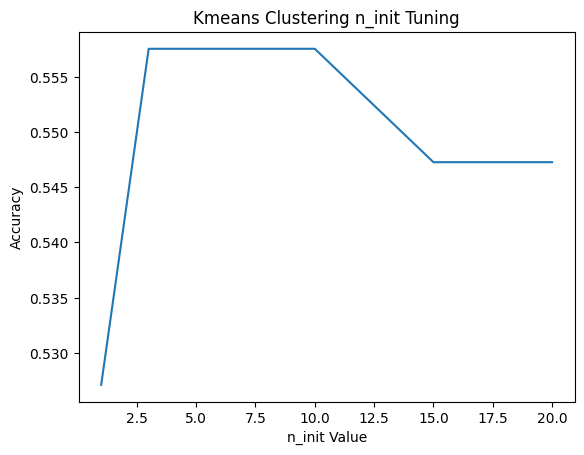

In [90]:

#Hyperparameters to tune for Kmeans
n_init = [1,3,4,5,6,7,8,9,10,15,20]

accs = []
for n in n_init:
    accs.append(perform_kmeans_clustering(X_normalized, n_init=n))

plt.plot(n_init, accs)
plt.title("Kmeans Clustering n_init Tuning")
plt.ylabel("Accuracy")
plt.xlabel("n_init Value")
plt.show()

## Results

After conducting the modeling and Hyperparameters our models performed as follows:

SVD + Logistic Regression - Best Accuracy = 0.940
- n_components = 75

NMF + Logistic Regression - Best Accuracy = 0.855
- n_components = 40

SVD + Agglomerative Clustering - Best Accuracy = 0.514
- affinity = 'euclidean'
- linkage = 'ward'

SVD + KMeans Clustering - Best Accuracy = 0.558
- n_init selected to be = 3

## Discussion

Non Negative Matrix Factorization (NMF) took a lot longer than Singular Value Decomposition (SVD), and SVD outperformed NMF by around 10% accuracy. This seemed a fairly significant difference for this dataset and indicates that SVD is better suited to this type of data. Following from this, SVD was selected to be the matrix factorization method of choice for the rest of this exploration.

Simple Logistic Regression performed on the Factorized Matrix was by far the best performer.

When it comes to the Unsupervised Clustering methods (Kmeans and Agglomerative) - we can see that they do not perform very well on this dataset. They perform significantly worse than simple Logistic Regression. This highlights the weakness of Unsupervised Methods to actually predict results. Unsupervised models are great for identifying the importance of features, for finding rough groupings of results that can be used to gain a better understanding of the structure of the data, and for reducing the size of the data to better feed Supervised Learning methods.

## Conclusion

This was a useful experiment to gain an understanding on the strengths and weaknesses of Unsupervised Machine Learning methods. They are useful for learning about our data and preparing our data, but we are better off using Supervised Methods to actually predict the labels (given labels are available).

For a next exploration it would be very interesting to go through the features ranked by importance and try to use just the most important feature versus other features and compare accuracy. This would help generate a good understanding of what that importance rating provided by the PCA module actually contributes to your models. Similarly, an analysis of excluding the least important features and observing the change in accuracy would be an interesting experiment to learn about what PCA can tell us.

Another thing that could be done better is to have a more reliable and extensive method to assigning the clustering grouping to actual labels for accuracy comparison. I wrote an imprecise method that will execute quickly for the interest of this experiment, but it is likely a few more percent of accuracy could be extracted with a more precise method for doing this.